This Jupyter notebook offers an engaging tutorial on using the PreFab library to predict the fabrication outcomes of a nanobeam structure, specifically imported from a GDS file, on a Silicon-On-Insulator (SOI) e-beam process. The tutorial encompasses:

1. Importing a device from a GDS file
2. Conducting a prediction
3. Analyzing the prediction
4. Writing the predicted device back to a GDS file

Initially, let's import the necessary libraries:

In [1]:
import matplotlib.pyplot as plt
import prefab as pf
import gdspy

We commence by importing a nanobeam device from a GDS file, transforming the geometric data into a numpy matrix with pixel values of either 0 or 1. We use a specific nanobeam design in this tutorial, but feel free to experiment with other designs in `devices/devices.gds`, or input your own GDS file!

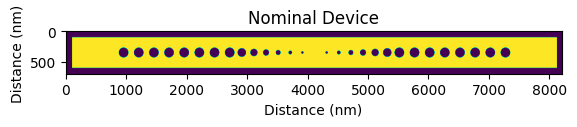

In [2]:
device = pf.load_device_gds(path='../devices/devices.gds', cell_name='nanobeam')

plt.imshow(device)
plt.title('Nominal Device')
plt.ylabel('Distance (nm)')
plt.xlabel('Distance (nm)')
plt.show()

Next, we predict the fabrication result for our nanobeam. Each model is uniquely tagged by its type ('p' for predictor), the fabrication facility and process name, model version, and training dataset version. Refer to `docs/models.md` for the list of available models.

The option to specify binarized output is also provided. The predictor by default generates raw predictions, inclusive of "fuzzy" areas of the structure that can vary across fabrication runs or even among different nanobeam instances on the same chip. Choosing binarized output lets the predictor supply the most probable post-fabrication outcome. Post-prediction binarization is also feasible, enabling comparison between raw and binarized predictions.

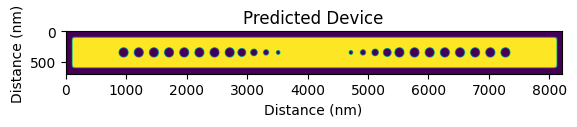

In [3]:
# Note: Initial prediction may take longer due to server startup and model loading. Subsequent predictions should be quicker.
MODEL_NAME = 'p_ANT_NanoSOI_v5'
MODEL_NUM = 'd4'
prediction = pf.predict(device=device, model_name=MODEL_NAME, model_num=MODEL_NUM)

plt.imshow(prediction)
plt.title('Predicted Device')
plt.ylabel('Distance (nm)')
plt.xlabel('Distance (nm)')
plt.show()

Finally, we proceed with an analysis of the prediction. A valuable approach here is to visualize potential deviations between the original nanobeam and the predicted outcome. This analysis can aid in identifying areas of high uncertainty in the fabrication process.

For our nanobeam, for instance, we may notice filling of the first two innermost holes and a general dilation of the larger holes. These are fabrication process artifacts, and understanding their potential appearance helps us to better predict and plan for the actual outcome.

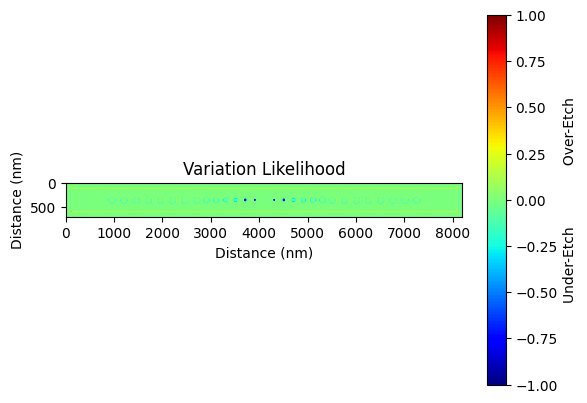

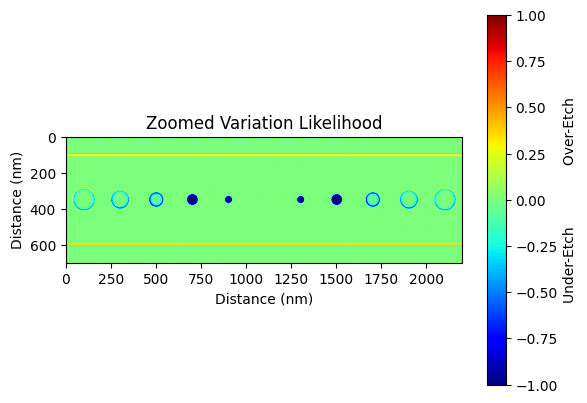

In [4]:
variation = device - prediction
plt.imshow(variation, cmap='jet', vmin=-1, vmax=1)
plt.title('Variation Likelihood')
plt.ylabel('Distance (nm)')
plt.xlabel('Distance (nm)')
cb = plt.colorbar()
cb.set_label('Under-Etch              Over-Etch')
plt.show()

plt.imshow(variation[0:-1, 3000:-3000], cmap='jet', vmin=-1, vmax=1)
plt.title('Zoomed Variation Likelihood')
plt.ylabel('Distance (nm)')
plt.xlabel('Distance (nm)')
cb = plt.colorbar()
cb.set_label('Under-Etch              Over-Etch')
plt.show()

Subsequently, we generate a GDS cell for the predicted binarized device and add it back to the original GDS library. The GDS file with the original and predicted devices can then be exported for further use or analysis.

In [5]:
gds_library = gdspy.GdsLibrary(infile='../devices/devices.gds')
predicted_nanobeam_cell = pf.device_to_cell(device=pf.binarize(prediction),
                                            cell_name='nanobeam_p',
                                            library=gds_library,
                                            resolution=1,
                                            layer=9)
origin = (-device.shape[1] / 2 / 1000, -device.shape[0] / 2 / 1000)
gds_library.cells['nanobeam'].add(gdspy.CellReference(ref_cell=predicted_nanobeam_cell, origin=origin))
gds_library.write_gds(outfile='../devices/devices.gds')

With this, we conclude the tutorial! You're now empowered to employ the predicted model of your nanobeam device and conduct simulations to forecast its performance. Furthermore, you might want to refine your nanobeam design to decrease variations and uncertainty (refer to device correction examples). This newfound understanding enables you to enhance your device fabrication processes. Happy fabricating!